In [1]:
import os

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

In [2]:
!pip install tensorflow_hub

# Accessing the Data

In [3]:
train_dir = 'train'     # the dataset from keggle was transformed: every cat-image was put into a subfolder 'cat' and every dog-image into a subfolder 'dog'
test_dir = 'test1'

In [4]:
target_size = (128, 128)
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    image_size=target_size,
    batch_size=32,           # if set to len(dataset) training the model won't probably be possible with your machine
    subset = "training",
    validation_split=0.3,
    seed=123,
    shuffle=True)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    image_size=target_size,
    batch_size=32,
    subset = "validation",
    validation_split=0.3,
    seed=123,
    shuffle=True)

Found 25000 files belonging to 2 classes.
Using 17500 files for training.


2024-01-16 10:26:59.656651: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-16 10:26:59.656678: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-16 10:26:59.656687: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-16 10:26:59.656733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 10:26:59.656752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25000 files belonging to 2 classes.
Using 7500 files for validation.


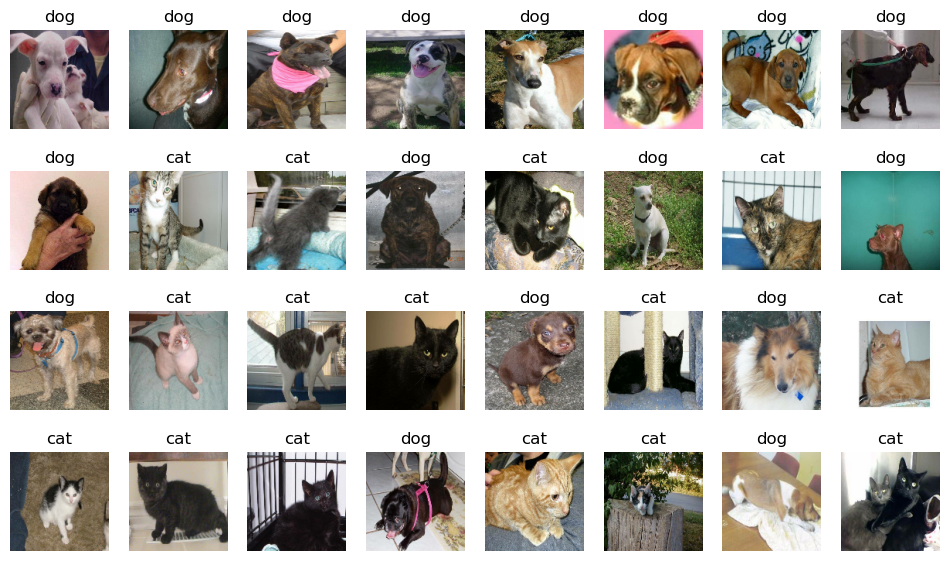

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(12, 7))
for images, labels in train_ds.take(1):
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


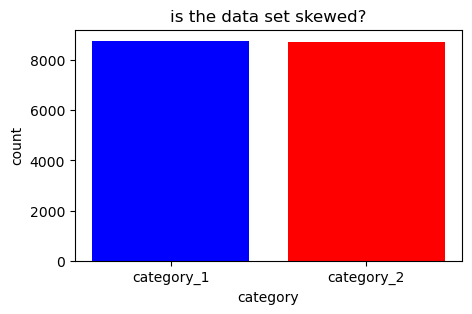

In [7]:
# checking if the dataset is skewed

train_label = np.concatenate([y for x, y in train_ds], axis=0)

category_1 = 0
category_2 = 0
for lbl in train_label:
    if lbl == 0:
        category_1 += 1
    else: category_2 += 1

categories = ['category_1', 'category_2']
counts = [category_1, category_2]
plt.figure(figsize=(5,3))
plt.bar(categories, counts, color=['blue', 'red'])
plt.xlabel('category')
plt.ylabel('count')
plt.title('is the data set skewed?')
plt.show()

In [8]:
# normalizing the data

def normalize_ds(image, label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(normalize_ds)
validation_ds = validation_ds.map(normalize_ds)

# Training the Model

In [9]:
path = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

model_hub = hub.KerasLayer(path, input_shape=(128,128,3), trainable=False)

model = tf.keras.Sequential([
    model_hub,
    tf.keras.layers.Dense(units=1000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(1000, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.legacy.Adam(), 
              metrics=['acc'])                            


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 1000)              1002000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 2695490 (10.28 MB)
Trainable params: 1003001 (3.83 MB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [11]:
history = model.fit(
              train_ds,
              validation_data=validation_ds,
              batch_size=32,
              #steps_per_epoch=100,
              epochs=3)

Epoch 1/3


2024-01-16 10:27:12.359080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


547/547 [==============================] - 45s 79ms/step - loss: 0.3876 - acc: 0.9101 - val_loss: 0.2285 - val_acc: 0.9315
Epoch 2/3
547/547 [==============================] - 46s 85ms/step - loss: 0.2558 - acc: 0.9210 - val_loss: 0.2068 - val_acc: 0.9339
Epoch 3/3
547/547 [==============================] - 44s 81ms/step - loss: 0.2589 - acc: 0.9218 - val_loss: 0.2160 - val_acc: 0.9324


In [12]:
history.history['val_acc'][-1]

0.9323999881744385